In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ml-bootcamp:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5397891%2F8966974%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240717%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240717T180022Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D90ccddd6c289173536b5756ed94de029c2392f1451df27f21415cb8a4c6d41b835af2d2f495d8d3eabdd633642ef8d10c43141bfe96649f3d5dde87d05b0650e3660c219e9ece03a5ec1f078307b27bd7bdf39a462208f7ac85a9b41c37e8806e74e9a06d432f63084a8db4527e0052ffb4927df1a69bf1067e7abf831de19a7859234fcd89a708c39db7fb0ff52e99063466ee85c2614b7b54db2579de2f2af155d5259db528aaef50ca3eed4a3e6a05bfd629286bb0f40a2b4008bd5dc3ea947e6bcd09b5ce55ab94ba61f8a7500087aec3a847856c225886b62f668098b3f1c739103e428878c8f4d57bac6fd3025e451f90096486218dc059292479818e8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


## EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

In [ ]:
train = pd.read_csv('/kaggle/input/ml-bootcamp/train.csv')
test = pd.read_csv('/kaggle/input/ml-bootcamp/test.csv')

In [ ]:
train.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [ ]:
test.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [ ]:
# id 열 삭제
train = train.drop(['id'], axis = 1)

In [ ]:
train.head(5)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [ ]:
# 결측치 확인
train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
# 데이터 타입 확인
train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
train['Vehicle_Age'].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [ ]:
# gender, vehicle_age, vehicle_damage 데이터 타입 변경
train['Gender'] = train['Gender'].map({'Male': 0, 'Female': 1})
train['Vehicle_Age'] = train['Vehicle_Age'].map({'1-2 Year' : 1, '> 2 Years' : 2, '< 1 Year' : 0})
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

In [ ]:
train.dtypes

Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,21,1,35.0,0,1,1,65101.0,124.0,187,0
1,0,43,1,28.0,0,2,1,58911.0,26.0,288,1
2,1,25,1,14.0,1,0,0,38043.0,152.0,254,0
3,1,35,1,1.0,0,1,1,2630.0,156.0,76,0
4,1,36,1,15.0,1,1,0,31951.0,152.0,294,0


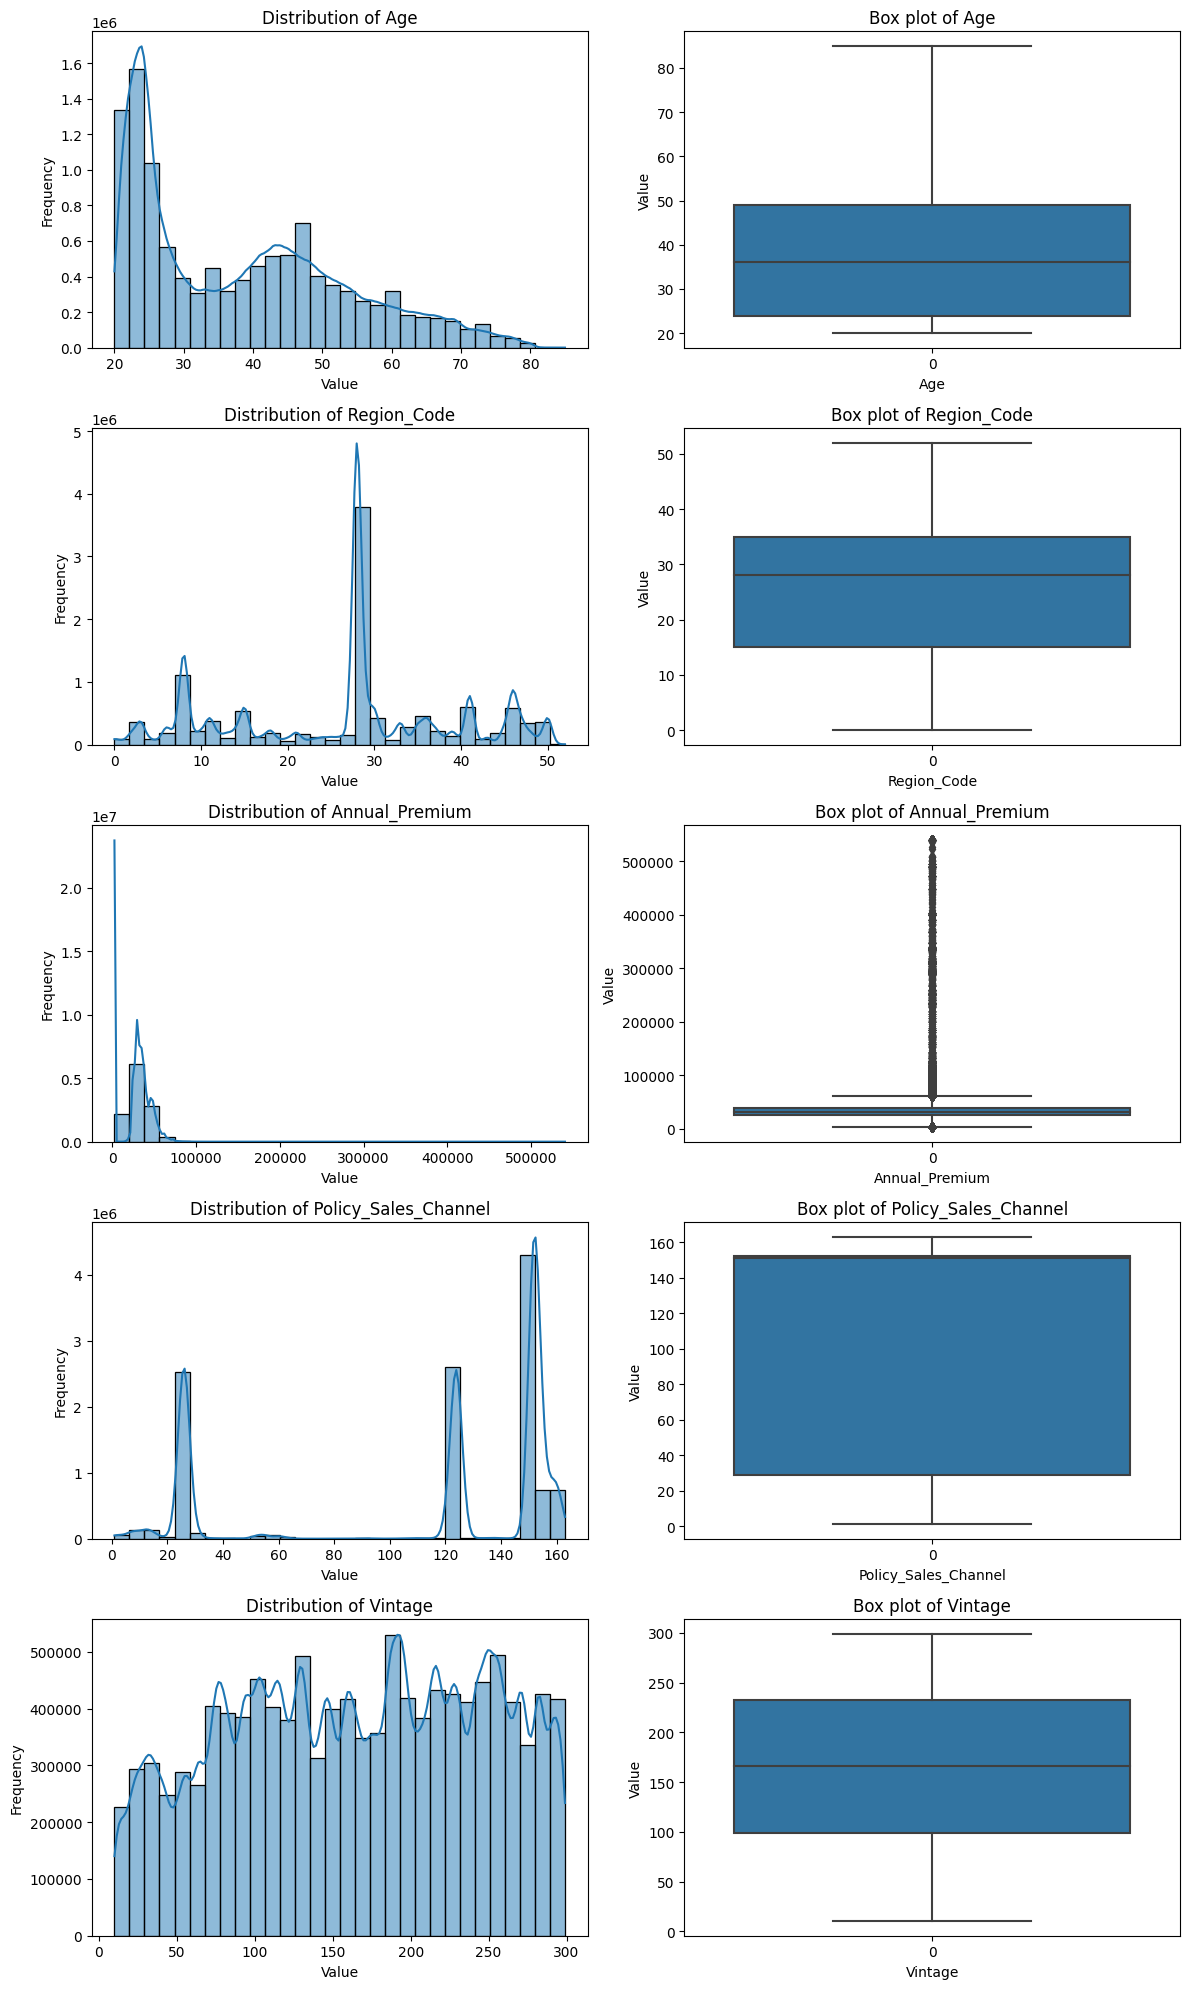

In [ ]:
# Check basic statistics for numerical columns
numerical = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# Create subplots for histograms and box plots
fig, axes = plt.subplots(len(numerical), 2, figsize=(12, 20))

# Plot the histograms and box plots
for i, column in enumerate(numerical):
    # Histogram
    sns.histplot(train[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(train[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box plot of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

-> 'Annual_Premium' 칼럼 이상치 다수 존재

In [ ]:
# numerical column 정규화
# scaler = StandardScaler()
# train[numerical] = scaler.fit_transform(train[numerical])
# train.head()

In [ ]:
# Age 최대, 최소값 확인
print("min :", train['Age'].min())
print("max :", train['Age'].max())

min : 20
max : 85


-> Age를 범주형으로 바꾸고, 나머지를 scaler해야 할듯

In [ ]:
# Age 범주형 변경

# 구간 설정
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, float('inf')]

# 각 구간에 대한 라벨 설정
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Age 열을 범주형 변수로 변환
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

- 0 : 20-24
- 1 : 25-29
- 2 : 30-34
- 3 : 35-39
- 4 : 40-44
- 5 : 45-49
- 6 : 50-54
- 7 : 55-59
- 8 : 60-64
- 9 : 65-69
- 10 : 70-74
- 11 : 75-79
- 12 : 80세 이상

In [ ]:
# Age 열 삭제
train = train.drop(['Age'], axis = 1)

In [ ]:
train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,35.0,0,1,1,65101.0,124.0,187,0,0
1,0,1,28.0,0,2,1,58911.0,26.0,288,1,4
2,1,1,14.0,1,0,0,38043.0,152.0,254,0,1
3,1,1,1.0,0,1,1,2630.0,156.0,76,0,3
4,1,1,15.0,1,1,0,31951.0,152.0,294,0,3


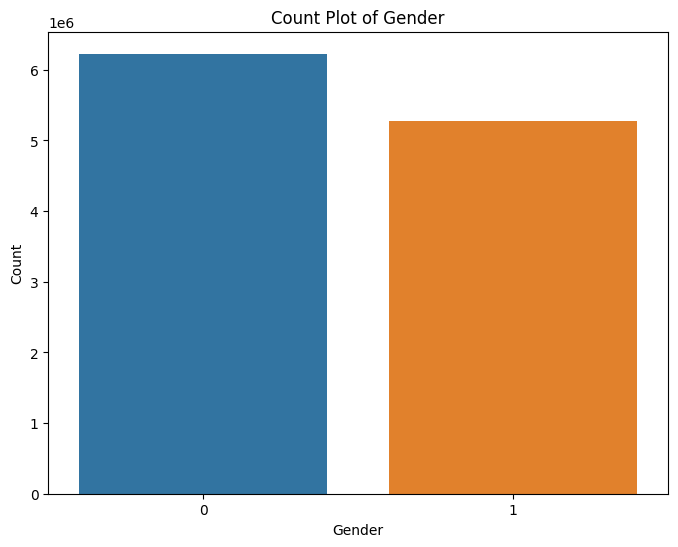

In [ ]:
# count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=train)
plt.title('Count Plot of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

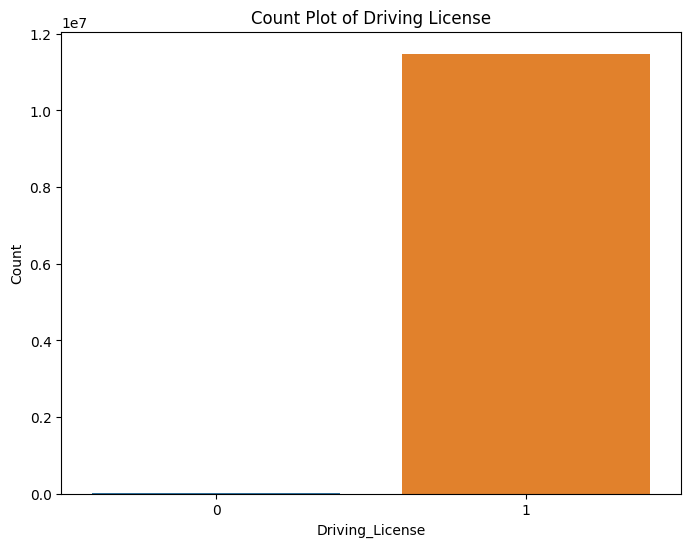

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Driving_License', data=train)
plt.title('Count Plot of Driving License')
plt.xlabel('Driving_License')
plt.ylabel('Count')
plt.show()

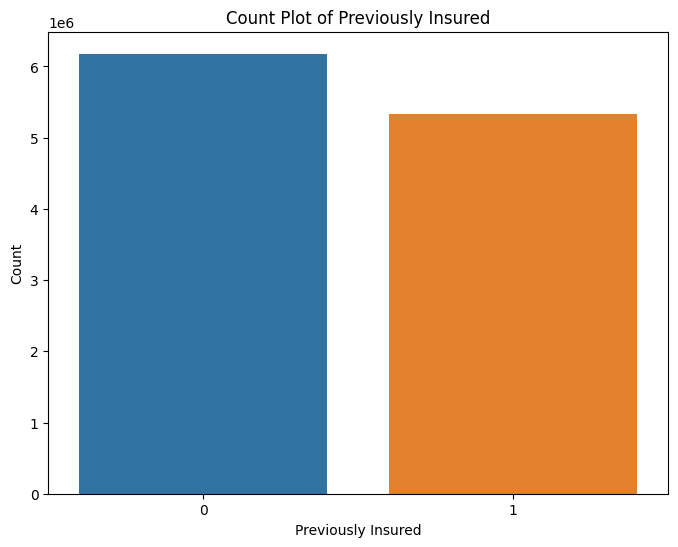

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Previously_Insured', data=train)
plt.title('Count Plot of Previously Insured')
plt.xlabel('Previously Insured')
plt.ylabel('Count')
plt.show()

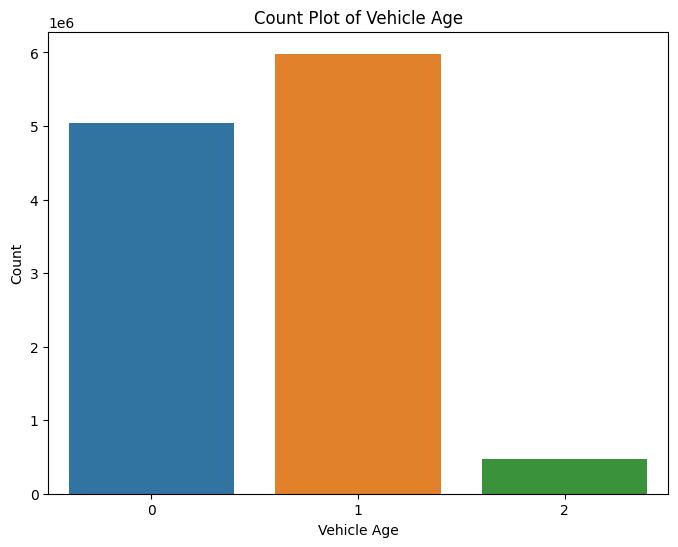

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Vehicle_Age', data=train)
plt.title('Count Plot of Vehicle Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

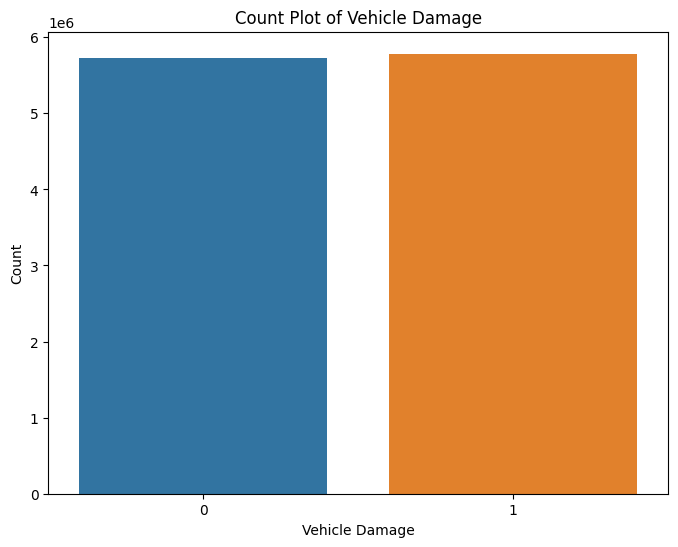

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Vehicle_Damage', data=train)
plt.title('Count Plot of Vehicle Damage')
plt.xlabel('Vehicle Damage')
plt.ylabel('Count')
plt.show()

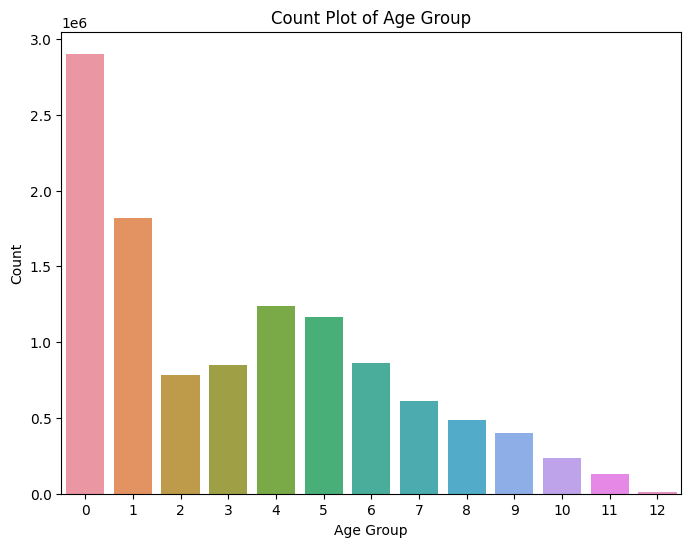

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='AgeGroup', data=train)
plt.title('Count Plot of Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

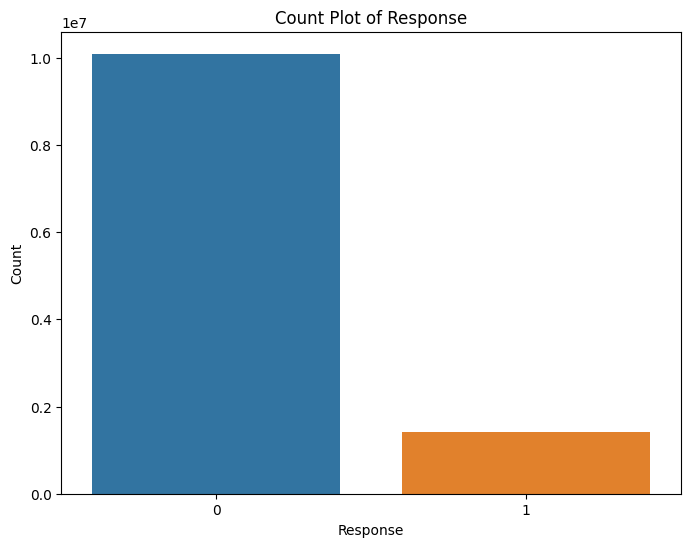

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Response', data=train)
plt.title('Count Plot of Response')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

In [ ]:
# numerical column 정규화
numerical = ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
scaler = StandardScaler()
train[numerical] = scaler.fit_transform(train[numerical])
train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.660528,0,1,1,2.105145,0.214202,0.288852,0,0
1,0,1,0.121718,0,2,1,1.728962,-1.599414,1.551675,1,4
2,1,1,-0.955902,1,0,0,0.460756,0.732378,1.126566,0,1
3,1,1,-1.956550,0,1,1,-1.691389,0.806403,-1.099003,0,3
4,1,1,-0.878929,1,1,0,0.090529,0.732378,1.626694,0,3


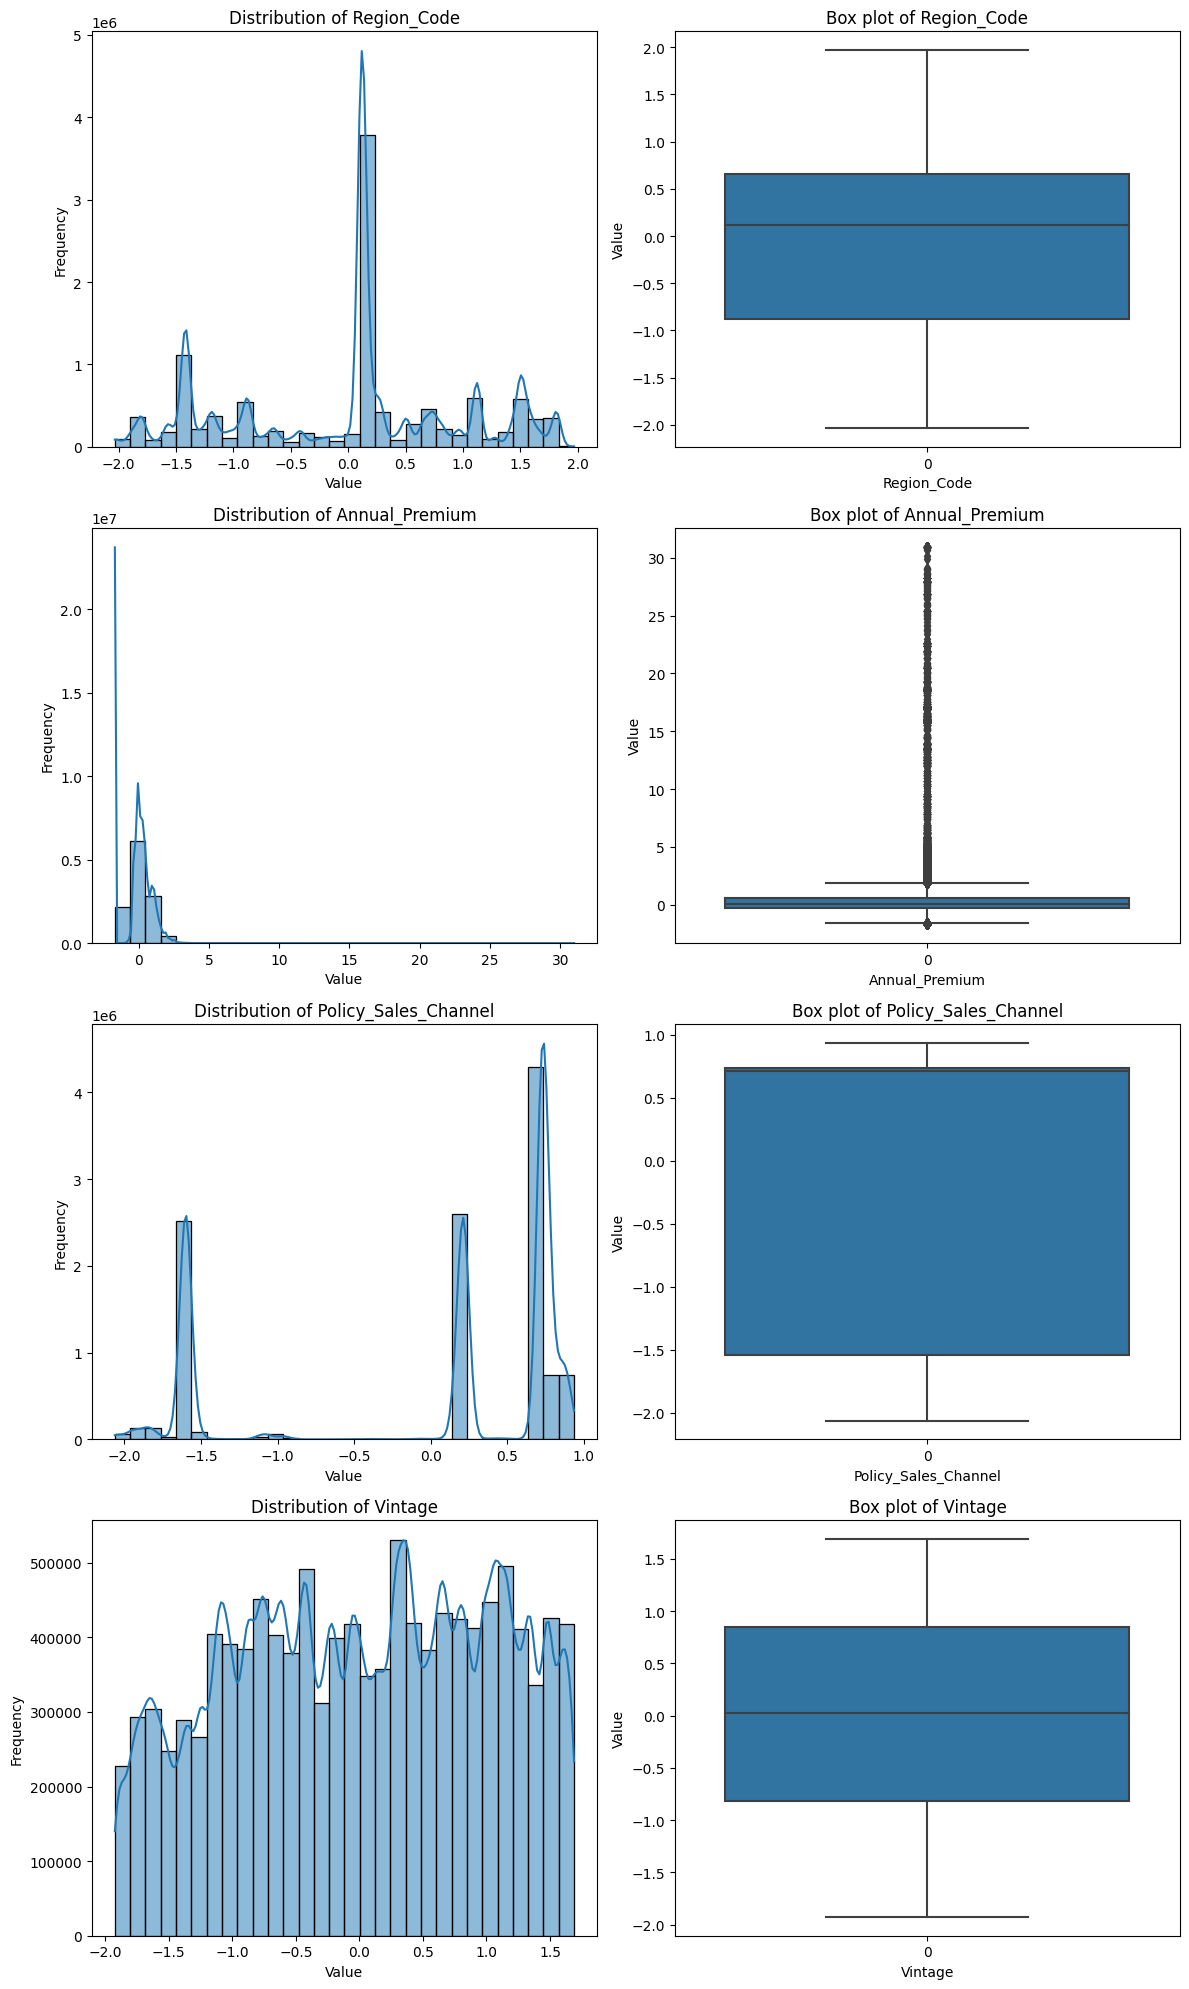

In [ ]:
# 정규화 이후 박스플랏 및 히스토그램
numerical = ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# Create subplots for histograms and box plots
fig, axes = plt.subplots(len(numerical), 2, figsize=(12, 20))

# Plot the histograms and box plots
for i, column in enumerate(numerical):
    # Histogram
    sns.histplot(train[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(train[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box plot of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

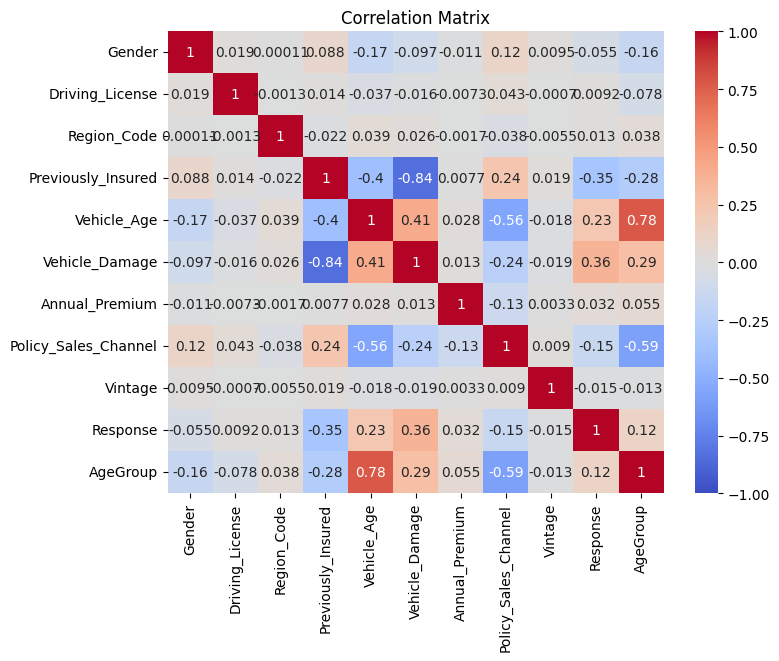

In [ ]:
# 상관계수 확인
correlation_matrix = train.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

[ 약한 양의 상관관계 ] - 0.2 이상, 0.4 미만
1. (Policy_Sales_Channel, Previously_Insured) : 0.24
2. (Response, Vehicle_Age) : 0.23
3. (AgeGroup, Vehicle_Damage) : 0.29
4. (Response, Vehicle_Damage) : 0.36

[ 약한 음의 상관관계 ]
1. (AgeGroup, Previously_Insured) : -0.28
2. (Response, Previously_Insured) : -0.35
3. (Policy_Sales_Channel, Vehicle_Damage) : -0.24

[ 강한 양의 상관관계 ]
1. (Vehicle_Damage, Vehicle_Age) : 0.41
2. (AgeGroup, Vehicle_Age): 0.78

[ 강한 음의 상관관계 ]
1. (Vehicle_Age, Previously_Insured) : -0.4
2. (Vehicle_Damage, Previously_Insured) : -0.84
3. (Policy_Sales_Channel, Vehicle_Age) : -0.56
4. (AgeGroup, Policy_Sales_Channel) : -0.59

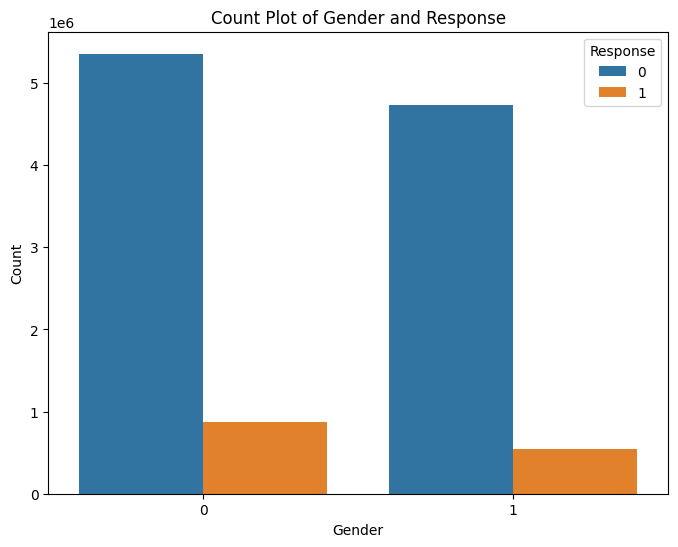

In [ ]:
# 각 칼럼 범주 별 response 분포

# Gender - Response
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Response', data=train)
plt.title('Count Plot of Gender and Response')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

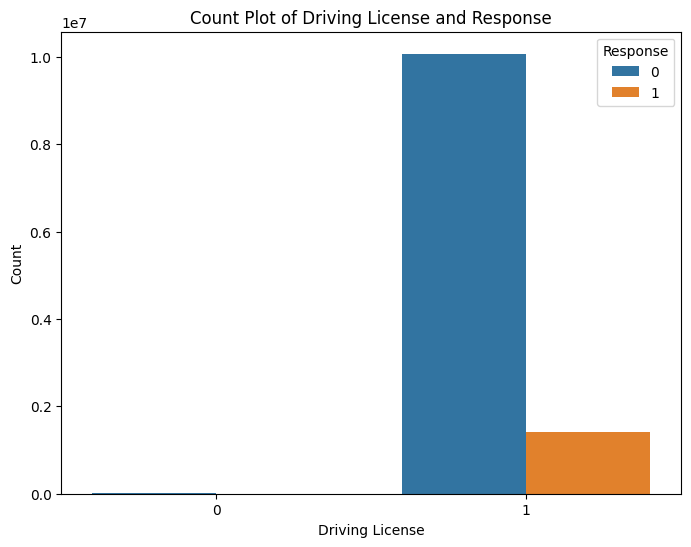

In [ ]:
# Driving_License - Response
plt.figure(figsize=(8, 6))
sns.countplot(x='Driving_License', hue='Response', data=train)
plt.title('Count Plot of Driving License and Response')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()

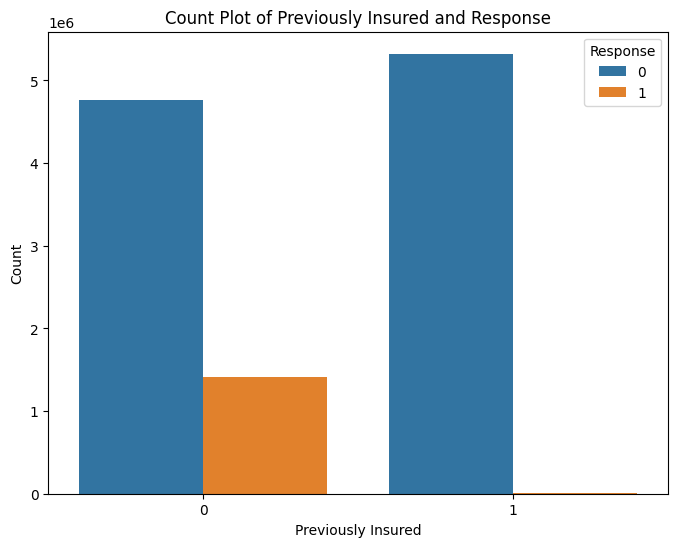

In [ ]:
# Previously_Insured - Response
plt.figure(figsize=(8, 6))
sns.countplot(x='Previously_Insured', hue='Response', data=train)
plt.title('Count Plot of Previously Insured and Response')
plt.xlabel('Previously Insured')
plt.ylabel('Count')
plt.show()

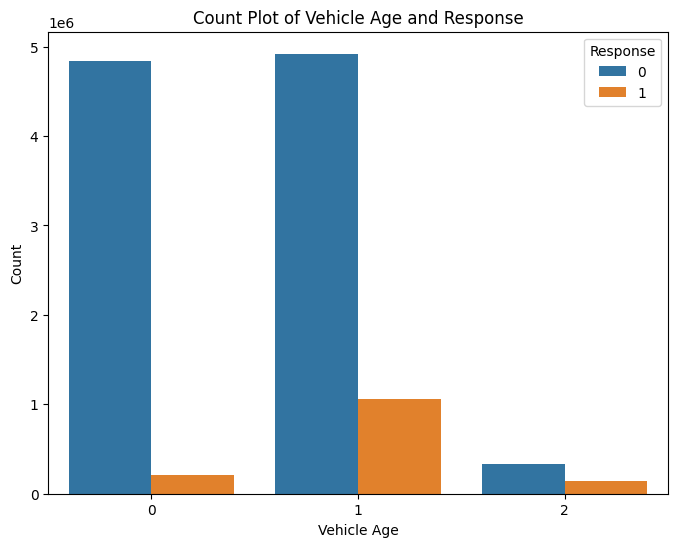

In [ ]:
# Vehicle_Age - Response
plt.figure(figsize=(8, 6))
sns.countplot(x='Vehicle_Age', hue='Response', data=train)
plt.title('Count Plot of Vehicle Age and Response')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

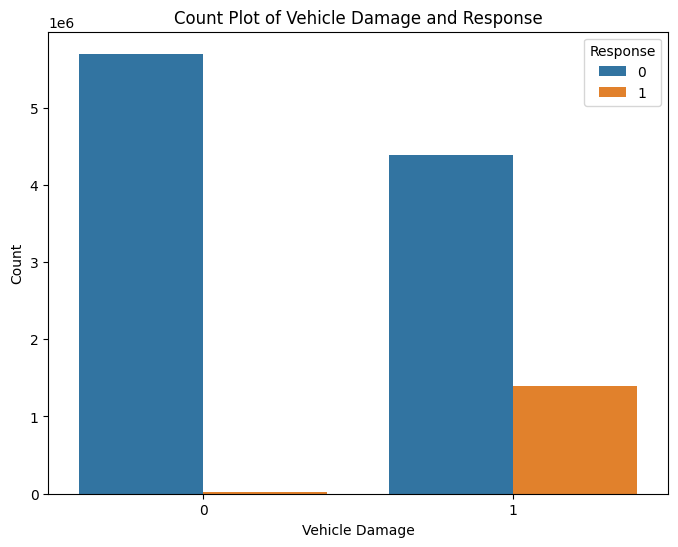

In [ ]:
# Vehicle_Damage - Response
plt.figure(figsize=(8, 6))
sns.countplot(x='Vehicle_Damage', hue='Response', data=train)
plt.title('Count Plot of Vehicle Damage and Response')
plt.xlabel('Vehicle Damage')
plt.ylabel('Count')
plt.show()

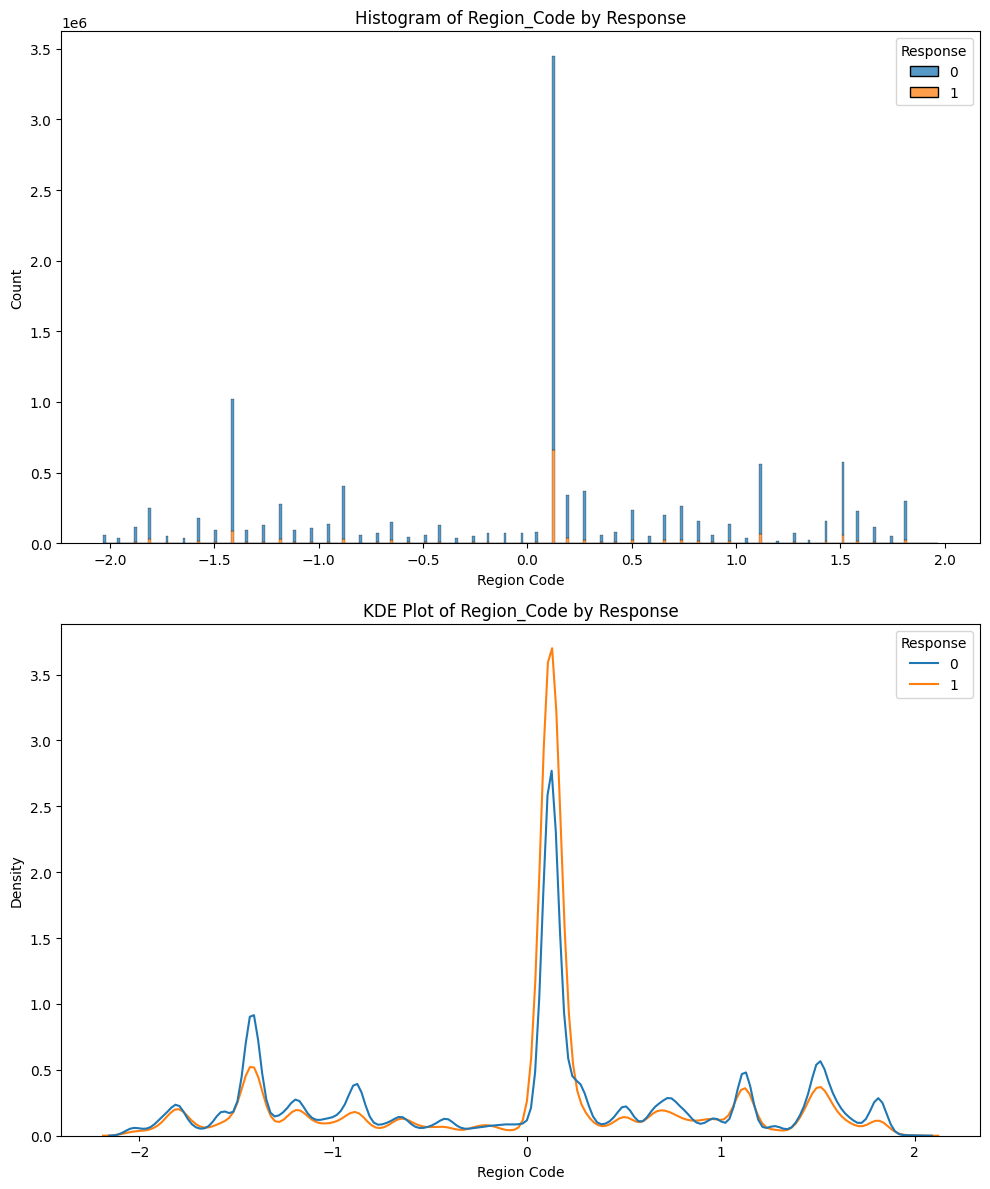

In [ ]:
# 서브플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# histplot
sns.histplot(data=train, x='Region_Code', hue='Response', multiple='stack', kde=False, ax=axes[0])
axes[0].set_title('Histogram of Region_Code by Response')
axes[0].set_xlabel('Region Code')
axes[0].set_ylabel('Count')

# kdeplot
sns.kdeplot(data=train, x='Region_Code', hue='Response', common_norm=False, ax=axes[1])
axes[1].set_title('KDE Plot of Region_Code by Response')
axes[1].set_xlabel('Region Code')
axes[1].set_ylabel('Density')

# 간격 조정
plt.tight_layout()
plt.show()

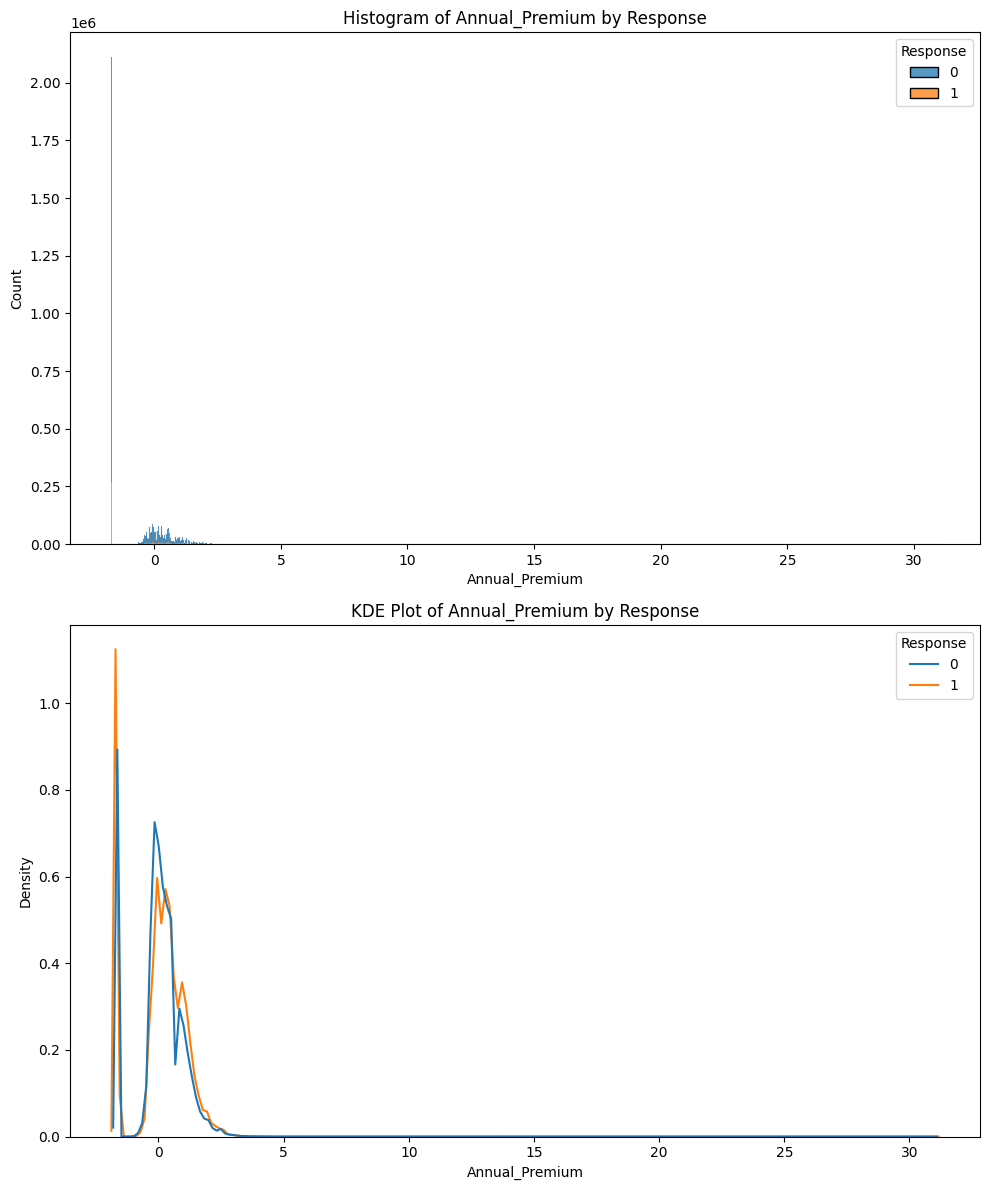

In [ ]:
# 서브플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# histplot
sns.histplot(data=train, x='Annual_Premium', hue='Response', multiple='stack', kde=False, ax=axes[0])
axes[0].set_title('Histogram of Annual_Premium by Response')
axes[0].set_xlabel('Annual_Premium')
axes[0].set_ylabel('Count')

# kdeplot
sns.kdeplot(data=train, x='Annual_Premium', hue='Response', common_norm=False, ax=axes[1])
axes[1].set_title('KDE Plot of Annual_Premium by Response')
axes[1].set_xlabel('Annual_Premium')
axes[1].set_ylabel('Density')

# 간격 조정
plt.tight_layout()
plt.show()

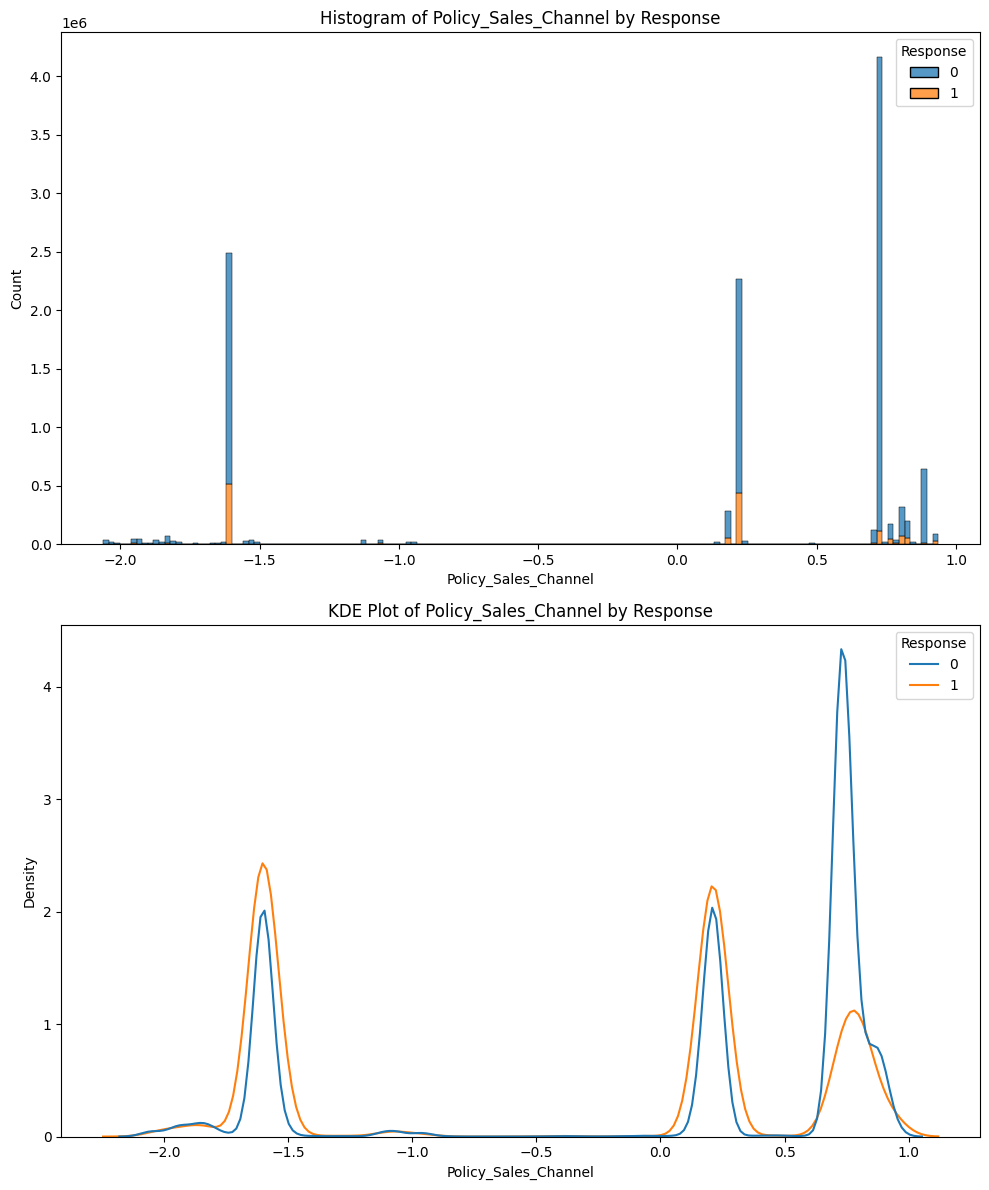

In [ ]:
# 서브플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# histplot
sns.histplot(data=train, x='Policy_Sales_Channel', hue='Response', multiple='stack', kde=False, ax=axes[0])
axes[0].set_title('Histogram of Policy_Sales_Channel by Response')
axes[0].set_xlabel('Policy_Sales_Channel')
axes[0].set_ylabel('Count')

# kdeplot
sns.kdeplot(data=train, x='Policy_Sales_Channel', hue='Response', common_norm=False, ax=axes[1])
axes[1].set_title('KDE Plot of Policy_Sales_Channel by Response')
axes[1].set_xlabel('Policy_Sales_Channel')
axes[1].set_ylabel('Density')

# 간격 조정
plt.tight_layout()
plt.show()

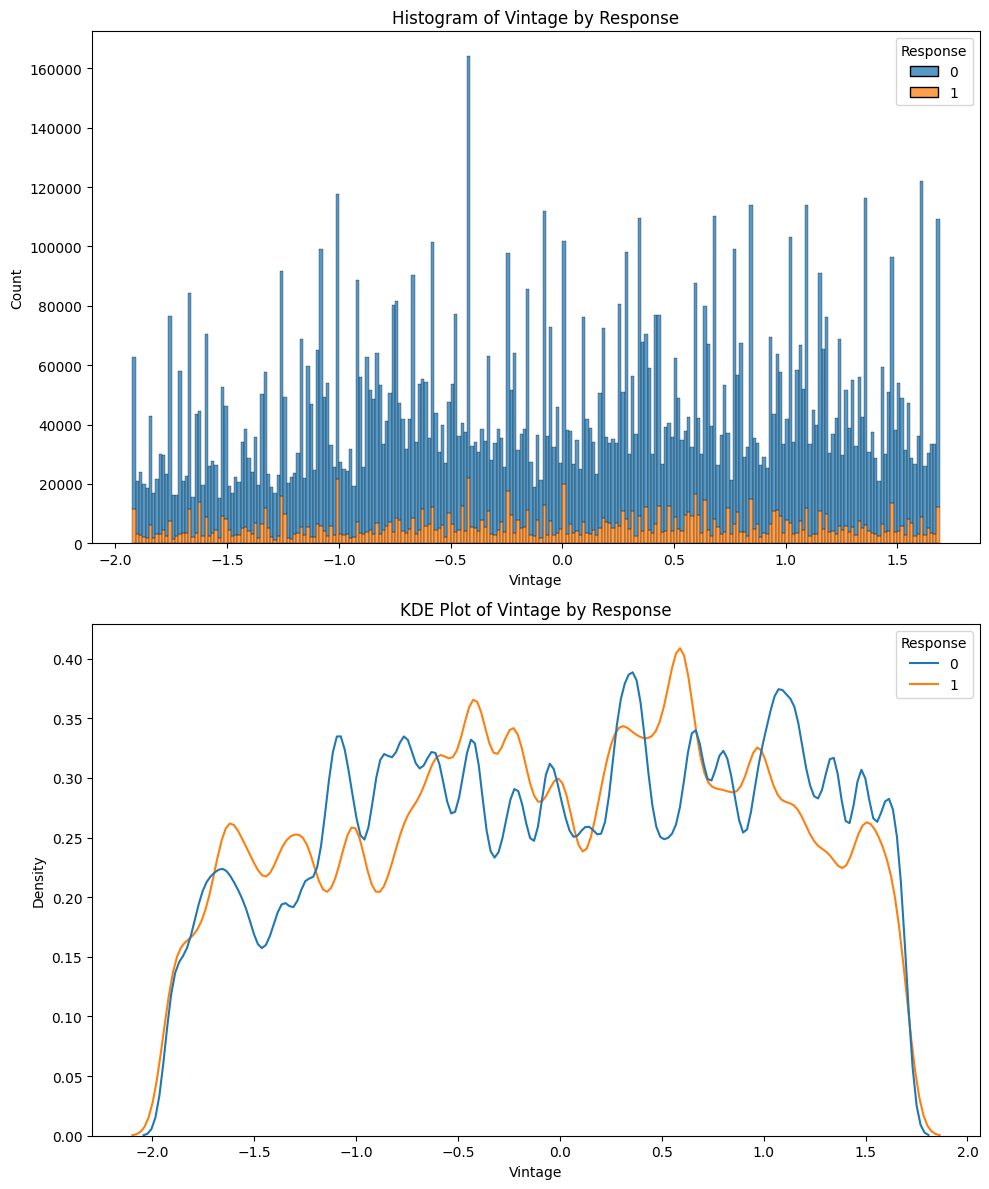

In [ ]:
# 서브플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# histplot
sns.histplot(data=train, x='Vintage', hue='Response', multiple='stack', kde=False, ax=axes[0])
axes[0].set_title('Histogram of Vintage by Response')
axes[0].set_xlabel('Vintage')
axes[0].set_ylabel('Count')

# kdeplot
sns.kdeplot(data=train, x='Vintage', hue='Response', common_norm=False, ax=axes[1])
axes[1].set_title('KDE Plot of Vintage by Response')
axes[1].set_xlabel('Vintage')
axes[1].set_ylabel('Density')

# 간격 조정
plt.tight_layout()
plt.show()

### 이상치 처리
1. 이상치 존재하는 행 삭제
2. 범주형 데이터로 처리

### 사용 모델
1. SVM
2. Gradient Boosting Tree
3. SGD Classifier
4. KNN
5. Decision Tree
6. Random Forest

## 1. 이상치 처리 안 한 train 데이터 활용

In [ ]:
train.shape

(11504798, 11)

In [ ]:
# 데이터 샘플 수가 많아 시간 소요가 커 5%만 활용
_, sample_df = train_test_split(train, test_size = 0.05, stratify = train['Response'], random_state = 42)

In [ ]:
df = sample_df.reset_index()
df = df.drop(['index'], axis = 1)
df.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.121718,1,1,1,1.280398,-1.599414,0.388878,0,6
1,1,1,0.814474,0,0,1,-0.061889,0.732378,1.151573,0,1
2,0,1,1.507230,1,1,0,-1.691389,-1.599414,-0.098747,0,9
3,1,1,0.121718,1,0,0,0.074242,0.732378,0.726464,0,0
4,1,1,0.121718,0,2,1,0.629097,0.214202,-0.411327,0,4


In [ ]:
df.shape

(575240, 11)

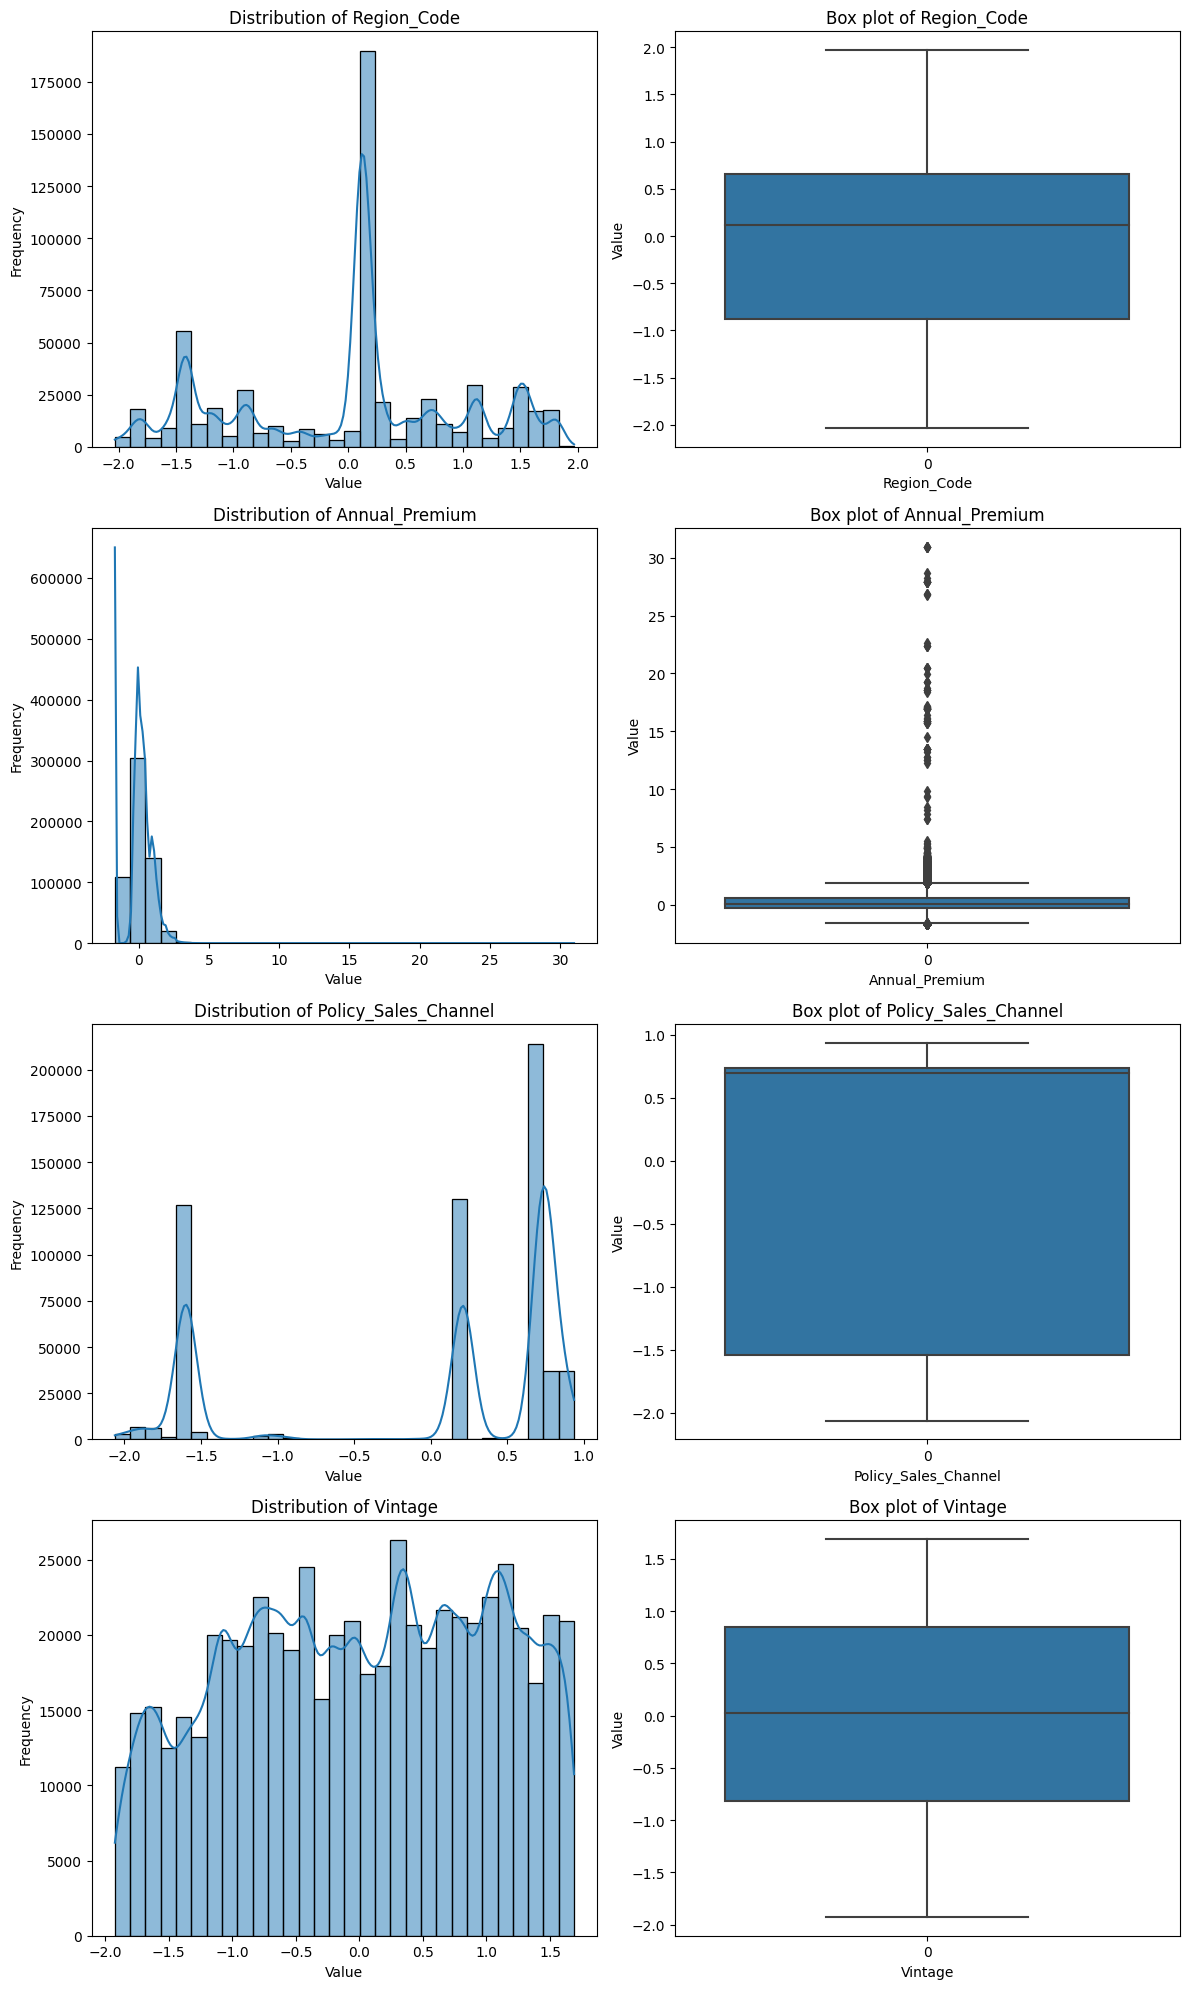

In [ ]:
# 분할 샘플 분포 확인해보기
numerical = ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# Create subplots for histograms and box plots
fig, axes = plt.subplots(len(numerical), 2, figsize=(12, 20))

# Plot the histograms and box plots
for i, column in enumerate(numerical):
    # Histogram
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box plot of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
# X, y 데이터
X = df.drop('Response', axis = 1)
y = df['Response']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1. SVM

In [ ]:
# svm_model = SVC(probability=True, random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
# n_samples = X_train.shape[0]
# chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

# for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    # end = i + chunk_size if i + chunk_size < n_samples else n_samples
    # svm_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
# y_score_svm = svm_model.predict_proba(X_test)[:, 1]
# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
# roc_auc_svm = auc(fpr_svm, tpr_svm)

In [ ]:
# 시각화
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

### 2. Gradient Boosting Tree

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    gb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_gb = gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

Training Progress: 100%|██████████| 21/21 [09:14<00:00, 26.42s/it]


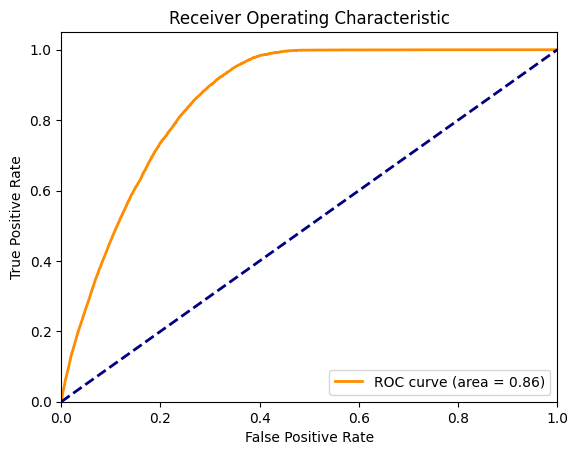

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. SGD Classifier

In [ ]:
sgd_model = SGDClassifier(loss='log', random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    sgd_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_sgd = sgd_model.decision_function(X_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_score_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

Training Progress: 100%|██████████| 21/21 [00:10<00:00,  1.91it/s]


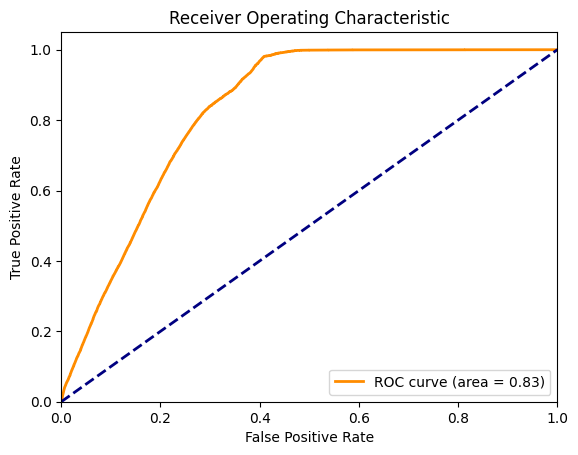

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    knn_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_knn = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

Training Progress: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


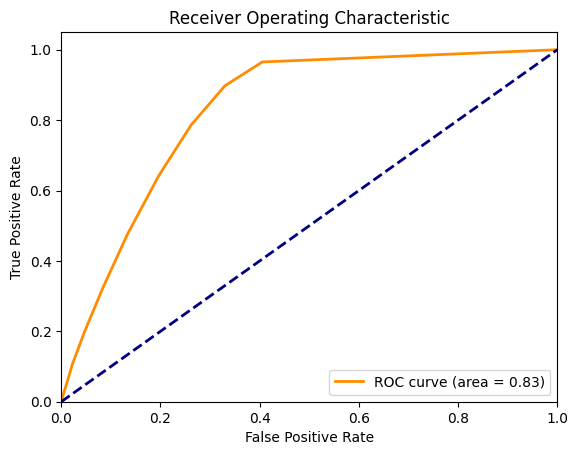

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    dt_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

Training Progress: 100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


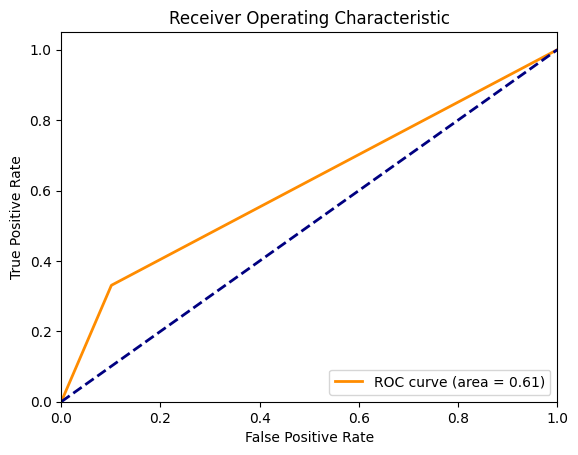

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    rf_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

Training Progress: 100%|██████████| 21/21 [15:23<00:00, 43.97s/it]


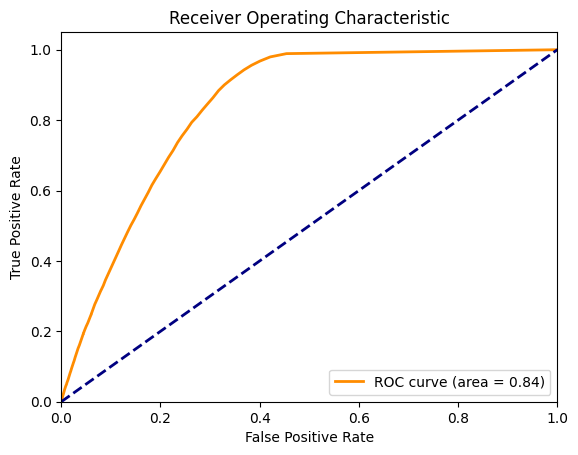

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 2. 이상치 존재하는 행 삭제 후 모델링

In [ ]:
# IQR을 이용하여 이상치 제거
Q1 = train['Annual_Premium'].quantile(0.25)
Q3 = train['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 있는 행 제거
deleted_train = train[(train['Annual_Premium'] >= lower_bound) & (train['Annual_Premium'] <= upper_bound)]

deleted_train.shape

(9127525, 11)

In [ ]:
# 데이터 샘플 수가 많아 시간 소요가 커 5%만 활용
_, sample_df2 = train_test_split(deleted_train, test_size = 0.05, stratify = deleted_train['Response'], random_state = 42)

In [ ]:
df2 = sample_df2.reset_index()
df2 = df2.drop(['index'], axis = 1)
df2.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.891447,0,1,1,0.204539,-1.599414,-1.811685,0,4
1,0,1,0.121718,1,1,0,0.188069,0.732378,-1.186525,0,11
2,1,1,-1.340767,1,0,0,0.387465,0.732378,0.588929,0,0
3,1,1,0.121718,0,1,1,0.385094,0.177189,0.001279,0,5
4,0,1,0.121718,0,1,1,0.530037,0.214202,0.151317,0,4


In [ ]:
df2.shape

(456377, 11)

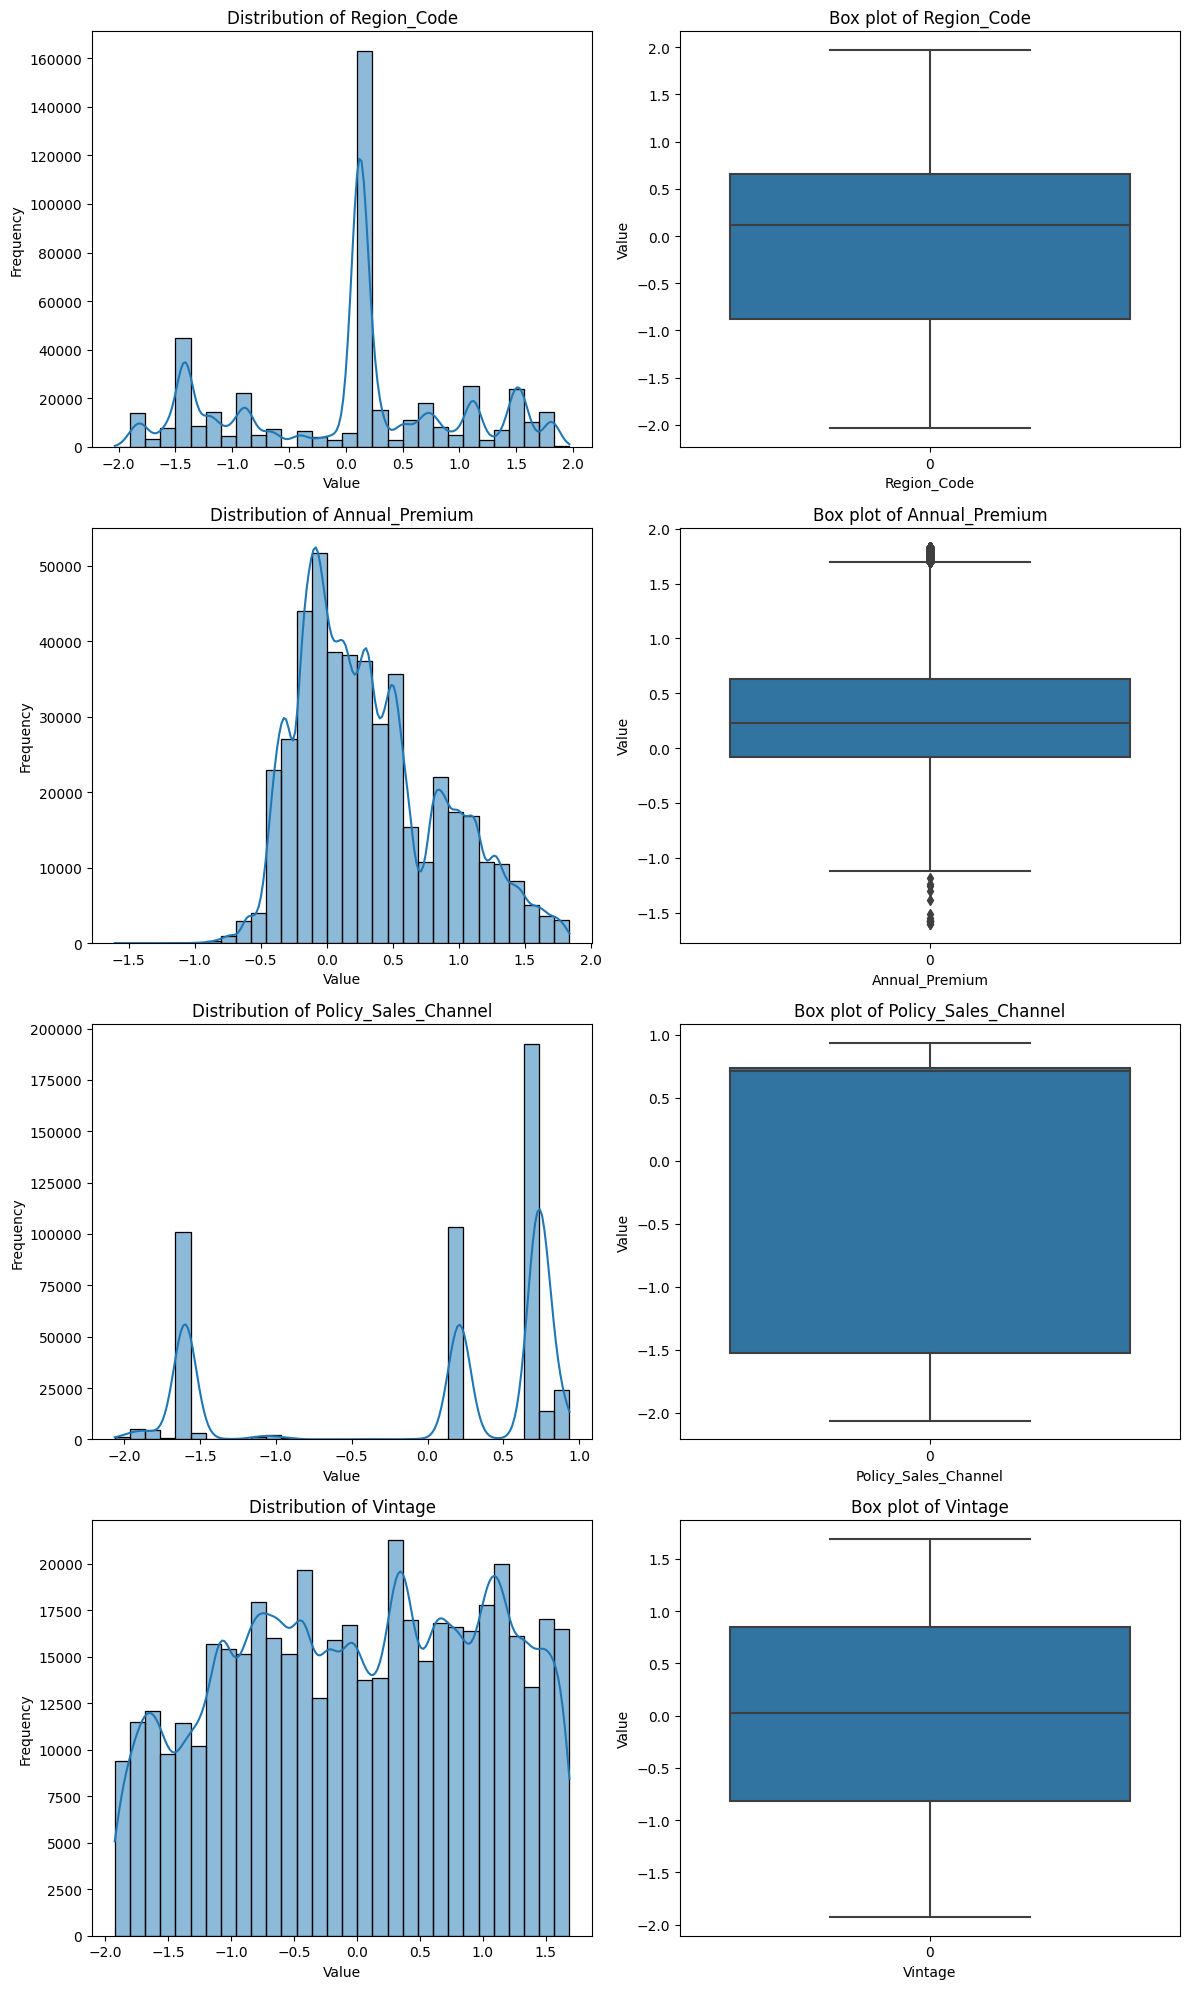

In [ ]:
#분할 샘플 분포 확인해보기
# numerical = ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# Create subplots for histograms and box plots
# fig, axes = plt.subplots(len(numerical), 2, figsize=(12, 20))

# Plot the histograms and box plots
# for i, column in enumerate(numerical):
    # Histogram
#     sns.histplot(df2[column], bins=30, kde=True, ax=axes[i, 0])
#     axes[i, 0].set_title(f'Distribution of {column}')
#     axes[i, 0].set_xlabel('Value')
#     axes[i, 0].set_ylabel('Frequency')

    # Box plot
#     sns.boxplot(df2[column], ax=axes[i, 1])
#     axes[i, 1].set_title(f'Box plot of {column}')
#     axes[i, 1].set_xlabel(column)
#     axes[i, 1].set_ylabel('Value')

# plt.tight_layout()
# plt.show()

In [ ]:
# X, y 데이터
X = df2.drop('Response', axis = 1)
y = df2['Response']

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1. SVM

In [ ]:
# svm_model = SVC(probability=True, random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
# n_samples = X_train.shape[0]
# chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

# for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    # end = i + chunk_size if i + chunk_size < n_samples else n_samples
    # svm_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
# y_score_svm = svm_model.predict_proba(X_test)[:, 1]
# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
# roc_auc_svm = auc(fpr_svm, tpr_svm)

In [ ]:
# 시각화
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

### 2. Gradient Boosting Tree

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    gb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_gb = gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

Training Progress: 100%|██████████| 21/21 [07:24<00:00, 21.16s/it]


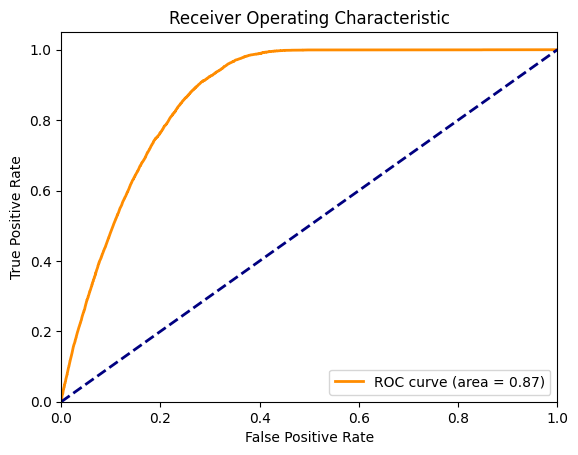

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. SGD Classifier

In [ ]:
sgd_model = SGDClassifier(loss='log', random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    sgd_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_sgd = sgd_model.decision_function(X_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_score_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

Training Progress: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


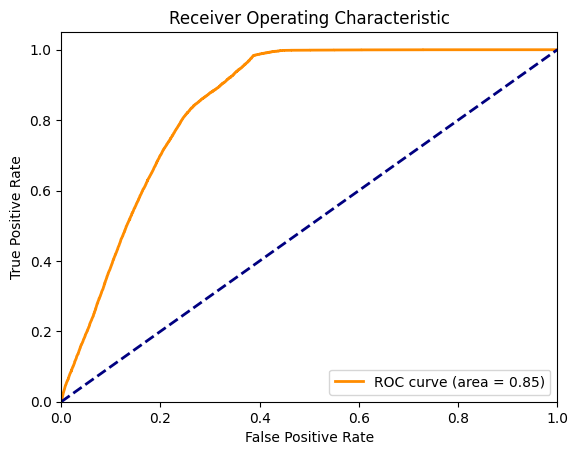

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    knn_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_knn = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

Training Progress: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


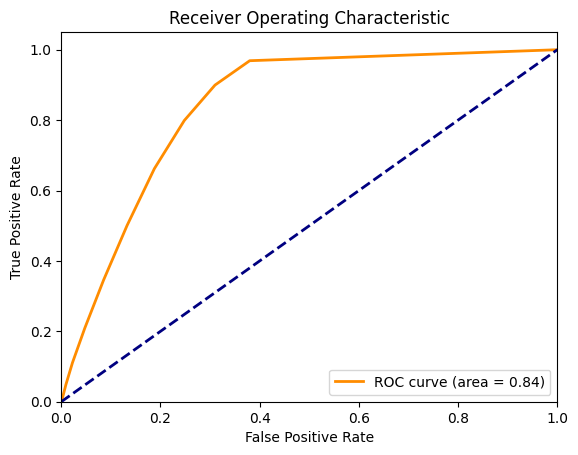

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    dt_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

Training Progress: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


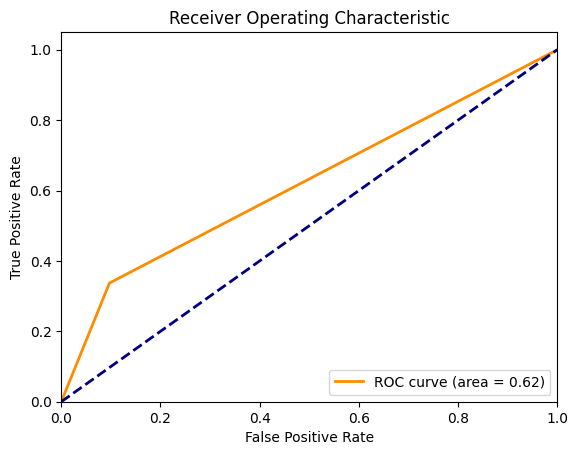

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    rf_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

Training Progress: 100%|██████████| 21/21 [11:55<00:00, 34.07s/it]


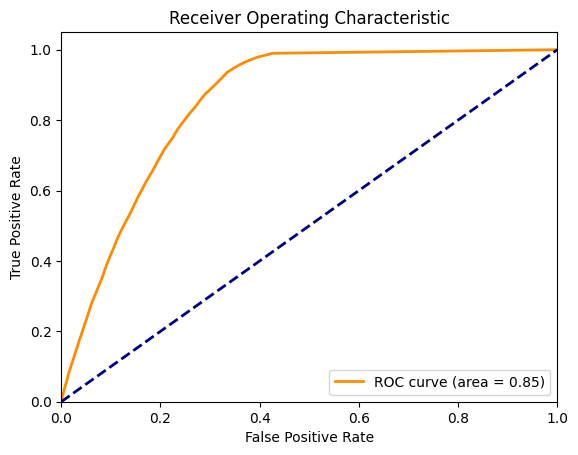

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 3. 범주화 후 모델링

In [ ]:
Q1 = train['Annual_Premium'].quantile(0.25)
Q3 = train['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 식별 및 라벨 5로 지정
train['Annual_Premium_Category'] = train['Annual_Premium'].apply(lambda x: 5 if x < lower_bound or x > upper_bound else None)

# 2. 이상치가 아닌 부분 범주화
# 이상치가 아닌 부분만 따로 추출
non_outliers = train[train['Annual_Premium_Category'].isnull()]['Annual_Premium']

# 5개의 구간으로 나누기
categories = pd.qcut(non_outliers, q=5, labels=False)

# 구간 라벨을 원래 데이터프레임에 적용
train.loc[train['Annual_Premium_Category'].isnull(), 'Annual_Premium_Category'] = categories

In [ ]:
train['Annual_Premium_Category'] = train['Annual_Premium_Category'].astype('int64')
train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup,Annual_Premium_Category
0,0,1,0.660528,0,1,1,2.105145,0.214202,0.288852,0,0,5
1,0,1,0.121718,0,2,1,1.728962,-1.599414,1.551675,1,4,4
2,1,1,-0.955902,1,0,0,0.460756,0.732378,1.126566,0,1,3
3,1,1,-1.956550,0,1,1,-1.691389,0.806403,-1.099003,0,3,5
4,1,1,-0.878929,1,1,0,0.090529,0.732378,1.626694,0,3,2


In [ ]:
df3 = train.drop(['Annual_Premium'], axis = 1)

In [ ]:
# 데이터 샘플 수가 많아 시간 소요가 커 5%만 활용
_, sample_df = train_test_split(df3, test_size = 0.05, stratify = df3['Response'], random_state = 42)

In [ ]:
df3 = sample_df.reset_index()
df3 = df3.drop(['index'], axis = 1)
df3.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Response,AgeGroup,Annual_Premium_Category
0,0,1,0.121718,1,1,1,-1.599414,0.388878,0,6,4
1,1,1,0.814474,0,0,1,0.732378,1.151573,0,1,1
2,0,1,1.507230,1,1,0,-1.599414,-0.098747,0,9,5
3,1,1,0.121718,1,0,0,0.732378,0.726464,0,0,1
4,1,1,0.121718,0,2,1,0.214202,-0.411327,0,4,3


In [ ]:
# X, y 데이터
X = df3.drop('Response', axis = 1)
y = df3['Response']

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1. SVM

In [ ]:
# svm_model = SVC(probability=True, random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
# n_samples = X_train.shape[0]
# chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

# for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    # end = i + chunk_size if i + chunk_size < n_samples else n_samples
    # svm_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
# y_score_svm = svm_model.predict_proba(X_test)[:, 1]
# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
# roc_auc_svm = auc(fpr_svm, tpr_svm)

In [ ]:
# 시각화
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

### 2. Gradient Boosting Tree

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    gb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_gb = gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

Training Progress: 100%|██████████| 21/21 [07:21<00:00, 21.03s/it]


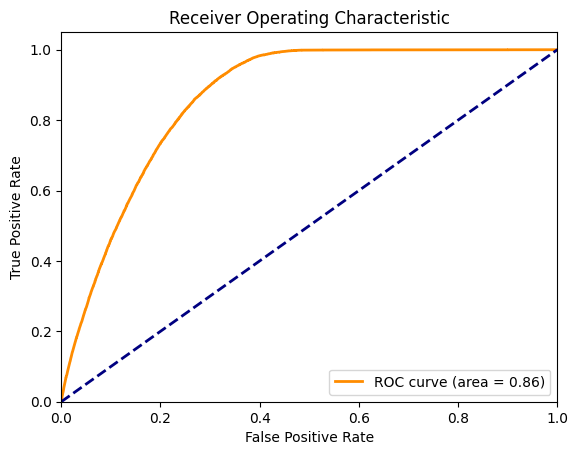

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. SGD Classifier

In [ ]:
sgd_model = SGDClassifier(loss='log', random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    sgd_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_sgd = sgd_model.decision_function(X_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_score_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

Training Progress: 100%|██████████| 21/21 [00:10<00:00,  1.98it/s]


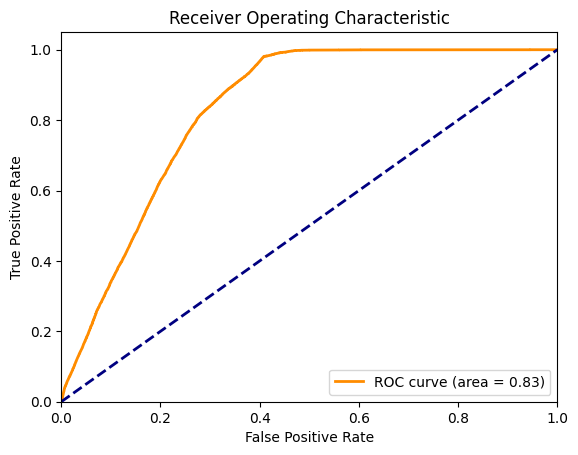

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    knn_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_knn = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

Training Progress: 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


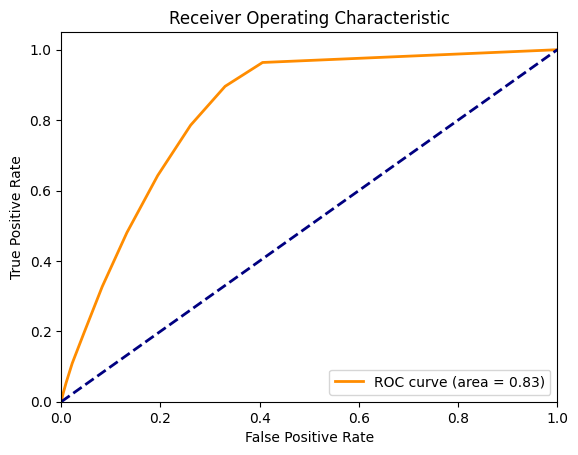

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    dt_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

Training Progress: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


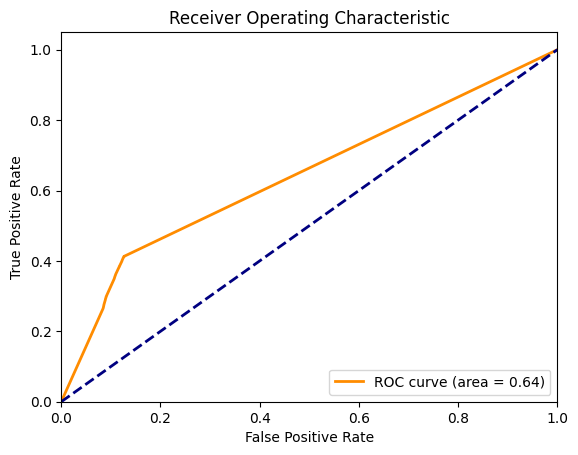

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    rf_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

Training Progress: 100%|██████████| 21/21 [12:31<00:00, 35.81s/it]


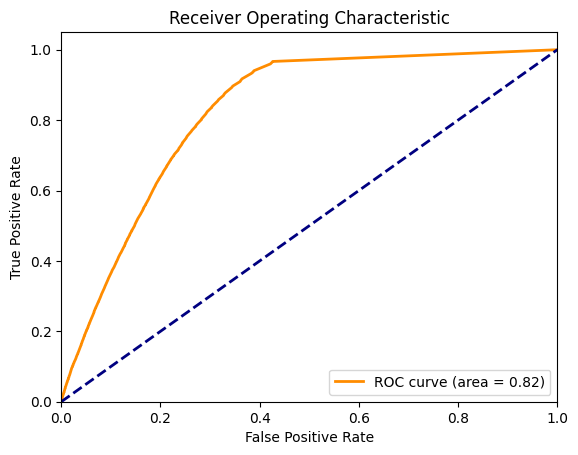

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Robust scaling 후 모델링

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup,Annual_Premium_Category
0,0,1,0.660528,0,1,1,2.105145,0.214202,0.288852,0,0,5
1,0,1,0.121718,0,2,1,1.728962,-1.599414,1.551675,1,4,4
2,1,1,-0.955902,1,0,0,0.460756,0.732378,1.126566,0,1,3
3,1,1,-1.956550,0,1,1,-1.691389,0.806403,-1.099003,0,3,5
4,1,1,-0.878929,1,1,0,0.090529,0.732378,1.626694,0,3,2


In [ ]:
# 이상치 식별
outliers = train[(train['Annual_Premium'] < lower_bound) | (train['Annual_Premium'] > upper_bound)]
non_outliers = train[(train['Annual_Premium'] >= lower_bound) & (train['Annual_Premium'] <= upper_bound)]

# 2. 이상치 스케일링
scaler = RobustScaler()
outliers_scaled = scaler.fit_transform(outliers[['Annual_Premium']])

# 스케일링된 이상치 값을 데이터프레임에 반영
train.loc[(train['Annual_Premium'] < lower_bound) | (train['Annual_Premium'] > upper_bound), 'Annual_Premium'] = outliers_scaled

In [ ]:
df4 = train.drop(['Annual_Premium_Category'], axis = 1)

In [ ]:
# 데이터 샘플 수가 많아 시간 소요가 커 5%만 활용
_, sample_df = train_test_split(df4, test_size = 0.05, stratify = df4['Response'], random_state = 42)

In [ ]:
df4 = sample_df.reset_index()
df4 = df4.drop(['index'], axis = 1)
df4.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.121718,1,1,1,1.280398,-1.599414,0.388878,0,6
1,1,1,0.814474,0,0,1,-0.061889,0.732378,1.151573,0,1
2,0,1,1.507230,1,1,0,0.000000,-1.599414,-0.098747,0,9
3,1,1,0.121718,1,0,0,0.074242,0.732378,0.726464,0,0
4,1,1,0.121718,0,2,1,0.629097,0.214202,-0.411327,0,4


In [ ]:
# X, y 데이터
X = df4.drop('Response', axis = 1)
y = df4['Response']

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1. SVM

In [ ]:
# svm_model = SVC(probability=True, random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
# n_samples = X_train.shape[0]
# chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

# for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    # end = i + chunk_size if i + chunk_size < n_samples else n_samples
    # svm_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
# y_score_svm = svm_model.predict_proba(X_test)[:, 1]
# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
# roc_auc_svm = auc(fpr_svm, tpr_svm)

In [ ]:
# 시각화
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

### 2. Gradient Boosting Tree

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    gb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_gb = gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

Training Progress: 100%|██████████| 21/21 [09:28<00:00, 27.08s/it]


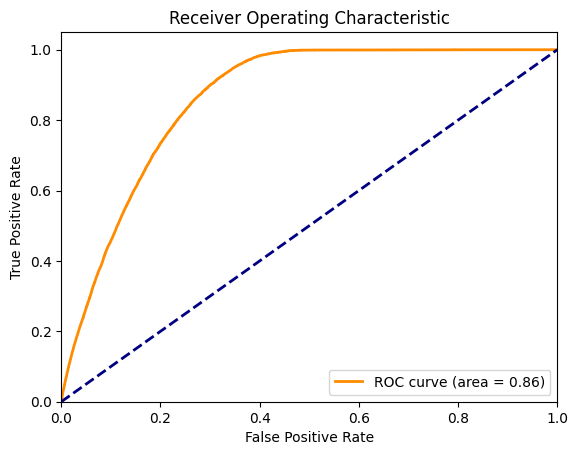

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. SGD Classifier

In [ ]:
sgd_model = SGDClassifier(loss='log', random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    sgd_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_sgd = sgd_model.decision_function(X_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_score_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

Training Progress: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


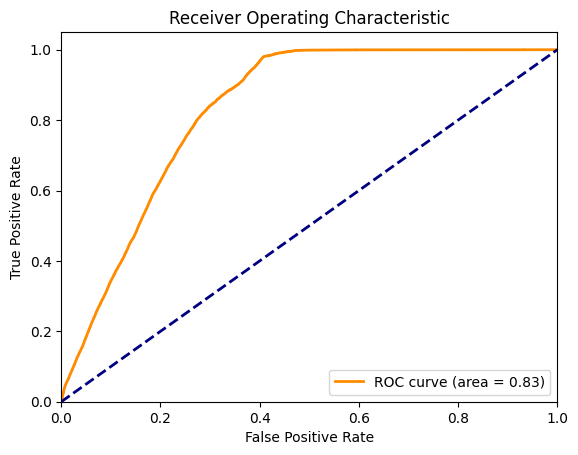

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    knn_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_knn = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

Training Progress: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


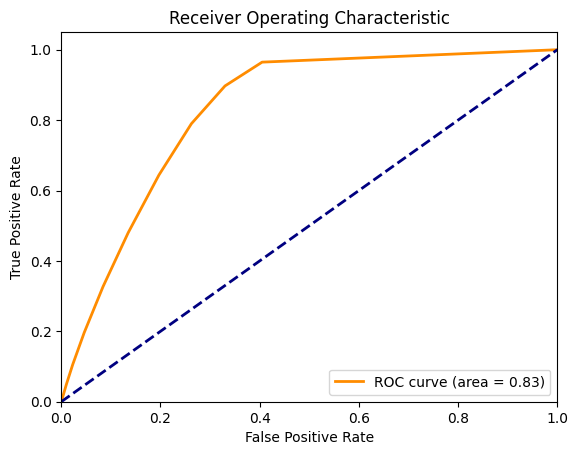

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    dt_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

Training Progress: 100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


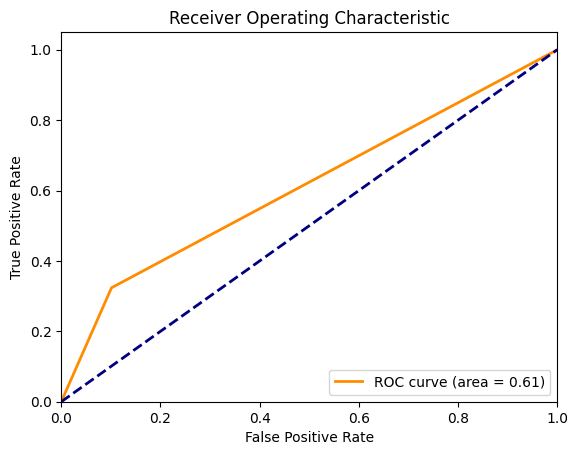

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    rf_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

Training Progress: 100%|██████████| 21/21 [15:26<00:00, 44.10s/it]


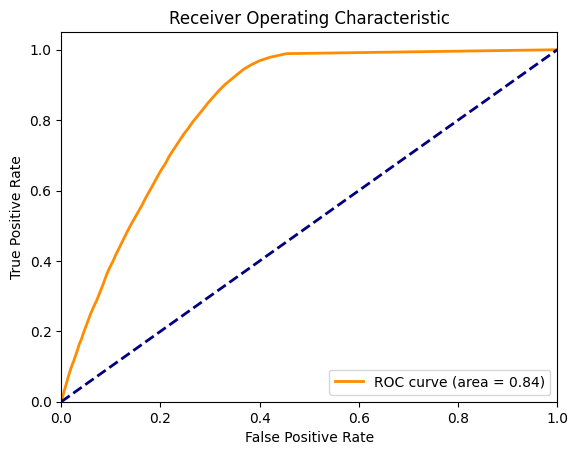

In [ ]:
# 시각화
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

[ 원래 데이터 ]
1. SVM
2. GBT : 0.86
3. SGD : 0.83
4. KNN : 0.83
5. DT : 0.61
6. RF : 0.84

[ 이상치 제거 데이터 ]
1. SVM
2. GBT : 0.87
3. SGD : 0.85
4. KNN : 0.84
5. DT : 0.62
6. RF : 0.85

[ 이상치 범주화 데이터 ]
1. SVM
2. GBT : 0.86
3. SGD : 0.83
4. KNN : 0.83
5. DT : 0.64
6. RF : 0.82

[ 이상치 RobustScale 데이터 ]
1. SVM
2. GBT : 0.86
3. SGD : 0.83
4. KNN : 0.83
5. DT : 0.5
6. RF : 0.84